# Assignment 1, E9 241 Digital Image Processing (DIP)

**Kartikeyan Iyer (SR No. 25922)**

### *0. Constants*

A cell for all the constants that we will be using

In [1]:
## Set up autoreload (for our modules)
%load_ext autoreload
%autoreload 2

In [2]:
## Constants
from assn1.constants import *

## *1. Histogram Computation*

Compute the histogram of the image `coins.png`, by finding the frequency of pixels for each intensity level ${0,1,...,255}$.
Show the histogram plot by plotting frequencies against intensity levels. Comment on what you observe. Also, find the average
intensity of the image using this histogram. Verify the result with the actual intensity.

| **Function**: Histogram |
| :------- |
| Input: Grayscale Image, threshold |
|Output: Frequencies at each intensity level (a vector/list of size 256)|

### *1.1 Load Image*

In this phase of the pipeline, read the image using `cv2.imread` function
and use `cv2.IMREAD_GRAYSCALE` parameter for reading as grayscale 

#### *1.1.1 Importing custom functions*

In the direcotry `assn1` many files relevent to different operations are going to be used.
They are the same thing as above but with more error checks added for debugging purposes.
The first of that is gonna be **reading and displaying the images**. 

Image Shape (height, width):  (203, 248) 


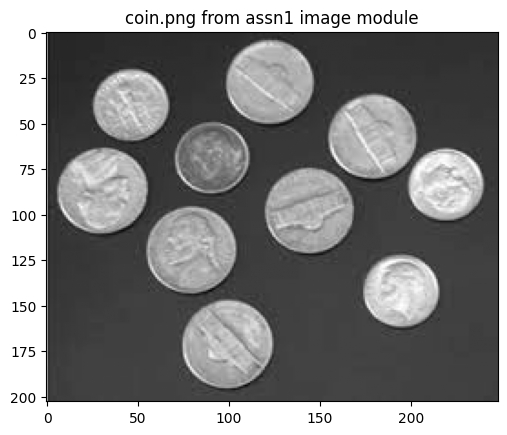

In [4]:
from assn1.image import load_image, display_image

## file path
filepath= './images/coins.png'

## load image (as grayscale)
img= load_image(filepath, grayscale= True)
print("Image Shape (height, width): \33[1;36m", img.shape,'\33[0m')

## display image
display_image(img, 'coin.png from assn1 image module', cmap='gray')

### *1.2. Compute Histogram*

The histogram computed is not normalized, for which the method is:
1. Create a zero intialized array of size *K* (256 in this case).
2. loop through all the pixels of the image and add 1 to the appropriate bin depending on pixel intensity
3. return the histogram which is a 256 size array of floats (since we normalize it later)

Implementations of functions found in `assn1/histogram.py`

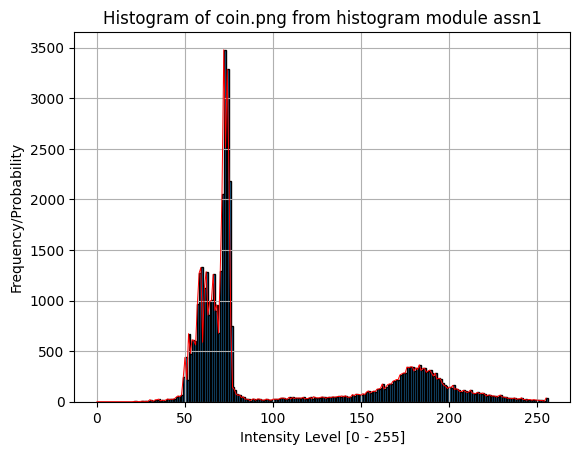

In [6]:
from assn1.histogram import histogram, display_histogram

## Compute histogram of img2
H1= histogram(img, normalized= False)

## display the histogram (bin edges handled by the function)
display_histogram(H1, title='Histogram of coin.png from histogram module assn1')

Verify whether things are good proper (sum of frequencies is the whole size)

In [7]:
import numpy as np 

np.sum(H1) == img.size

np.True_

#### **Observations**

1. More pixels are concentrated towards the darker intensity levels hence this is consistent that there are small light patches (coins) in a darker background.
2. The dark and bright pixels form a cluster again consistent with the nature of image.
3. The thresholding algorithm should yield nice results in this image, threshold lies somewhere around 80-100 range (eyeballing)

### *1.3. Comparison with NumPy Histogram*

The `np.hist` functions is going to be used.
1. Flatten the image into a 1D vector (for feeding into the hist function)
2. Define the bin edges (0, 1, 2.....) and the resp. bins will be $[0,1), [1,2),...,[255,256)$. Each bin contains the pixels of lower limit value only.
3. Use `np.hist` on the two.

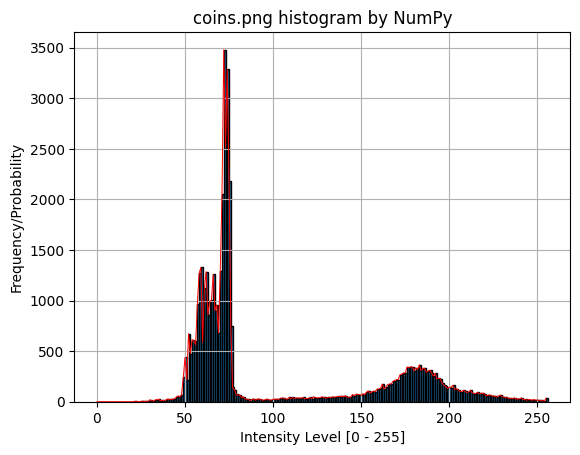

Are the H1 and H2 same histograms?  True 


In [9]:
import numpy as np

## flatten image
img_flat= img.flatten()

## create bin edges: [0,1,...,256] and take histogram
bin_edges= list(range(0,K+1))
H2, bins= np.histogram(img_flat, bins=bin_edges)

## display
display_histogram(H2, title='coins.png histogram by NumPy')

## compare with our histogram
print("Are the H1 and H2 same histograms? \33[1;36m",np.allclose(H2,H1, atol=1e-6),'\33[0m')

### *1.4 Calculating Average Intensities*

**a. Direct formula**

If $I\in \{0,1,...K-1\}^{M\times N}$ is the image matrix, then the average intensity is given by:
$$
\begin{equation}\tag{1}
I_{\text{avg}}= \frac{1}{M\cdot N}\sum_{i=0}^{M-1}\sum_{j=0}^{N-1}I(i,j)
\end{equation}
$$

which is basically summing over all pixel intensities and dividing them by total number of pixels, simple stuff. This can be achieved in code by 
`np.sum`.

**b. From Histogram**

Histogram is a function $H:\{0,1,...,K-1\}\rightarrow \{0,1,...,M\cdot N\}$ such that $H(k)$ is the number times the intensity level of $k$ occurs in the image $I$.<br>

The above formula can be modified so that pixels intensities of same value are grouped together, hence the summation index changing from $k= 0$ to $255$.

$$
I_{\text{avg}}= \frac{1}{M\cdot N}\sum_{k=0}^{K-1}k.H(k)
$$


**Comparing them computationally**

Since the two averages will be floating points, we don't compare them using `==` operator, any small difference by even $10^{-6}$ due to floating point arithmetic can cause them to be unequal. So, we use `np.allclose` which decides whether two quantities are equal with a tolerance which is $10^{-6}$ here,
the precision of `np.float32`.

**Verifying equivalence**

In [10]:
from assn1.image import avg_intensity
from assn1.histogram import hist_average

I_avg1= avg_intensity(img)
I_avg2= hist_average(H1)

print("Are both of them same? (to a good enough tolerance?)\33[1;36m", np.allclose(I_avg1, I_avg2, atol=1e-6), '\33[0m')
print(f"Average Intensity: {I_avg1:.4f}")

Are both of them same? (to a good enough tolerance?) True 
Average Intensity: 103.3050


Hence, the direct computation and the histogram computation are equal (to 6 decimal places at the very least)

## *2. Otsu's Binarization*
In the class, we showed that $\sigma^2_w(t) + \sigma^2_b(t)= \sigma^2_T$, where $t$ is the threshold for binarization.
- (a) Binarize the image `coins.png` by finding the optimal threshold $t$ by minimizing the within class variance $\sigma^2_w(t)$ over $t$.
- (b) Create a new image by adding offset of 20 to every pixel in `coins.png`. Binarize this new image by finding optimal threshold $t$ by maximizing the 
between class variance.

| **Function** Within class variance | **Function** Between class variance |
| :------- | :------ |
| Input: Grayscale Image, threshold  | Input: Grayscale image, threshold  |
| Output: Within class variance  | Output: Between class variance  |

### *2.1 Minimizing within class variance* $\sigma^2_w(t)$

The function will take up an image:
1. Compute the histogram (normalized)
2. Compute overall mean for image
3. Compute class probabilities, means and variances for given threshold $t$

The overall time complexity of the algo is: $\mathcal{O}(K)$

$$
\begin{aligned}
& \textbf{Algorithm 2.1.1: } \text{Within Class Variance}(I, t) \\
& \textbf{Input: } \text{An Image } I\in\{0,1,...,K-1\}^{M\times N}, \text{ theshold value } t\in{0,1,...,K-1} \\
& \textbf{Output: } \text{Within Class Variance } \sigma^2_w \\
\\
& \# \textbf{Calculating the overall mean } \mu_T \rightarrow \mathcal{O}(K) \\
& p = \text{compute-histogram}(I) \qquad\qquad \# K\text{-length array} \\
& \mu_T = 0 \\
& \textbf{for } k=0,1,...K-1:\\
& \qquad \mu_T += k\cdot p(k)\\
& \textbf{end for} \\
\\
& \# \textbf{Calculating the class 0 mean and prob } \mu_0(t), \omega_0(t) \rightarrow \mathcal{O}(t) \\
& \omega_0, \mu_0 = 0, 0 \\
& \textbf{for } k=0,1,...t: \\
& \qquad \omega_0 += p(k) \\
& \qquad \mu_0 += k\cdot p(k) \\
& \textbf{end for} \\
\\
& \# \textbf{Calculating the class 1 mean and prob } \mu_1(t), \omega_1(t) \\
& \omega_1 = 1-\omega_0 \\
& \mu_1= \frac{1}{\omega_1}(\mu_T - \omega_0\cdot\mu_0) \textbf{ if } \omega_1 \neq 0 \textbf{ else } 0\\
\\
& \# \textbf{Calculating the class variances } \sigma^2_0(t), \sigma^2_1(t) \rightarrow \mathcal{O}(K) \\
& \sigma^2_0, \sigma^2_1= 0,0 \\
& \textbf{for }  k= 0,1,...,t: \\
& \qquad \sigma^2_0+= (k-\mu_0)^2\cdot p(k) \\
& \textbf{end for} \\
& \textbf{for }  k= t+1,t+2,...,K-1: \\
& \qquad \sigma^2_1+= (k-\mu_1)^2\cdot p(k) \\
& \textbf{end for} \\
\\
& \# \textbf{Calculating the within class variance } \sigma^2_w(t) \\
& \sigma^2_w= \omega_0\cdot\sigma^2_0 + \omega_1\cdot\sigma^2_1 \\
& \textbf{return } \sigma^2_w
\end{aligned}
$$

<hr style="width=30%; margin=auto">

$$
\begin{aligned}
& \textbf{Algorithm 2.1.2: } \text{Between Class Variance}(I, t) \\
& \textbf{Input: } \text{An Image } I\in\{0,1,...,K-1\}^{M\times N}, \text{ theshold value } t\in{0,1,...,K-1} \\
& \textbf{Output: } \text{Between Class Variance } \sigma^2_b \\
\\
& \# \textbf{Calculating the overall mean } \mu_T \rightarrow \mathcal{O}(K) \\
& p = \text{compute-histogram}(I) \qquad\qquad \# K\text{-length array} \\
& \mu_T = 0 \\
& \textbf{for } k=0,1,...K-1:\\
& \qquad \mu_T += k\cdot p(k)\\
& \textbf{end for} \\
\\
& \# \textbf{Calculating the class 0 mean and prob } \mu_0(t), \omega_0(t) \rightarrow \mathcal{O}(t) \\
& \omega_0, \mu_0 = 0, 0 \\
& \textbf{for } k=0,1,...t: \\
& \qquad \omega_0 += p(k) \\
& \qquad \mu_0 += k\cdot p(k) \\
& \textbf{end for} \\
\\
& \# \textbf{Calculating the class 1 mean and prob } \mu_1(t), \omega_1(t) \\
& \omega_1 = 1-\omega_0 \\
& \mu_1= \frac{1}{\omega_1}(\mu_T - \omega_0\cdot\mu_0) \textbf{ if } \omega_1 \neq 0 \textbf{ else } 0\\
\\
& \# \textbf{Calculating the between class variance } \sigma^2_b(t) \\
& \sigma^2_w= \omega_0\cdot(\mu_0 - \mu_T)^2 + \omega_1(\mu_1 - \mu_T)^2 \\
& \textbf{return } \sigma^2_w
\end{aligned}
$$

\* for implementations, see `assn1/binarize.py`

In [16]:
## Set up autoreload (for our modules)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### *2.1.1 Testing Binarization code* 

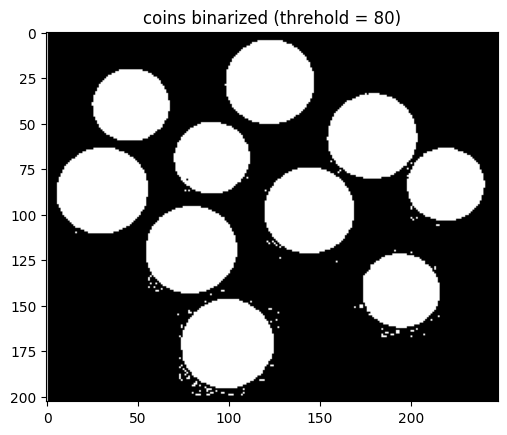

In [17]:
from assn1.binarize import binarize
from assn1.image import display_image, load_image

## load image for testing
filepath= './images/coins.png'
img= load_image(filepath, grayscale= True)

## binarize it with some random threshold
t= 80
img_bin= binarize(img, t)

## display it
display_image(img_bin, f'coins binarized (threhold = {t})')


### *2.1.2 Otsu Algo for minimizing* $\sigma^2_w(t)$

The approach is to iterate through all possible thresholds from 0 to 255 and see which minimizes
$\sigma^2_w(t)$:
1. Compute normalized histogram for image and the overall mean as well.
2. for all values of t, maintain a running value of $\omega_0, \omega_1, \mu_0, \mu_1$
3. using another for loop for a particular t, compute $\sigma^2_0, \sigma^2_1$

$$
\begin{align*}
& \textbf{Algorithm 2.1.2.1: } \text{Otsu Algorithm (Within Class)}(I) \\
& \textbf{Input: } \text{An Image } I\in\{0,1,...,K-1\}^{M\times N} \\
& \textbf{Output: } \text{Varaince array }\Sigma_w,\text{optimal Threshold } t \\
\\
& \# \text{ Compute histogram (normalized)} \\
& p= \text{compute-histogram}(I) \\
\\
& \# \text{ Compute overall mean and variance} \\
& \mu_T = 0 \\
& \textbf{for } k=0,1,...,K-1: \\
& \qquad \mu_T += k\cdot p[k] \\
& \textbf{end for} \\
& \textbf{for } k=0,1,...,K-1: \\
& \qquad \sigma_T += (k-\mu_T)^2\cdot p[k] \\
& \textbf{end for}\\
\\
& \# \text{ Running variables} \\
& \omega_0, m_0= 0,0 \\
& m_1 = \mu_T \\
& \Sigma_w = \text{zero-array}(K) \\ 
\\
& \textbf{for } t=0,1,...,K-1: \\
& \qquad \# \text{ Update Running Vars} \\
& \qquad \omega_0 += p[t]   \\
& \qquad m_0 += t \cdot p[t] \\
& \qquad \omega_1 = 1- \omega_0 \\
& \qquad m_1 -= t \cdot p[t] \\
\\
& \qquad \mu_0, \mu_1 = \frac{m_0}{\omega_0}, \frac{m_1}{\omega_1} \\
\\
& \qquad \# \text{ Calculate the class varainces} \\
& \qquad v_0, v_1 = 0, 0 \qquad \# \text{ Not variances, but class variance multiplied with class prob} \\
& \qquad \textbf{for } k=0,1,...t: \\
& \qquad \qquad v_0 += (k-\mu_0)^2\cdot p(k) \\
& \qquad \textbf{end for} \\
& \qquad \textbf{for } k=t+1,...,K-1: \\
& \qquad \qquad v_1 += (k-\mu_1)^2\cdot p(k) \\
& \qquad \textbf{end for} \\
& \qquad \Sigma_w [t] = v_0 + v_1 \\
& \textbf{end for} \\
& \textbf{return } \Sigma_w, \underset{t}{argmin}\Sigma_w

\end{align*}
$$

Implementation in `assn1/binarize.py` with some practical things considered. The overall complexity of the algo is $\mathcal{O}(K^2)$

In [18]:
from assn1.binarize import otsu_within_class

var_w, t_opt= otsu_within_class(img)

print(f"Optimal Threshold by minimizing within class variance is: \33[1;36m{t_opt}\33[0m")

Optimal Threshold by minimizing within class variance is: 125


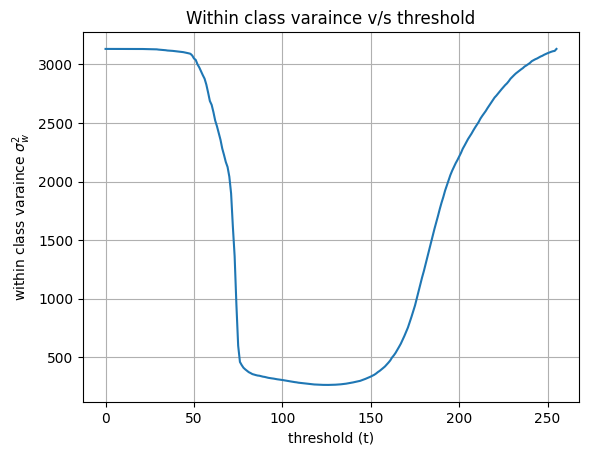

In [19]:
import matplotlib.pyplot as plt

plt.plot(var_w)
plt.title("Within class varaince v/s threshold")
plt.xlabel('threshold (t)')
plt.ylabel('within class varaince $\sigma^2_w$')
plt.grid(True)
plt.show()

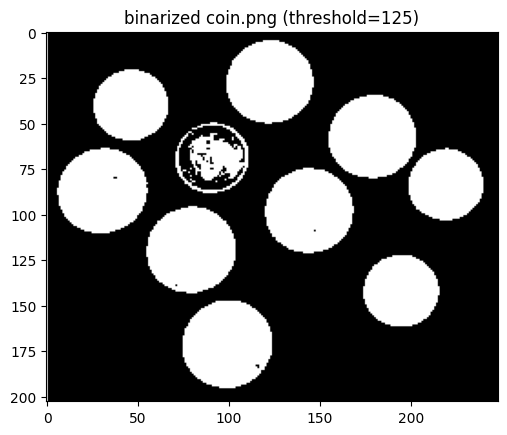

In [20]:
img_bin= binarize(img, t_opt)
display_image(img_bin, f'binarized coin.png (threshold={t_opt})')

### *2.2 Otsu Between class version*

This one maximizes between class variance $\sigma^2_b(t)$ and find the threshold.

$$
\begin{align*}
& \textbf{Algorithm 2.2.1: } \text{Otsu Algorithm (Within Class)}(I) \\
& \textbf{Input: } \text{An Image } I\in\{0,1,...,K-1\}^{M\times N} \\
& \textbf{Output: } \text{Variance array }\Sigma_b,\text{optimal Threshold } t \\
\\
& \# \text{ Compute histogram (normalized)} \\
& p= \text{compute-histogram}(I) \\
\\
& \# \text{ Compute overall mean and variance} \\
& \mu_T = 0 \\
& \textbf{for } k=0,1,...,K-1: \\
& \qquad \mu_T += k\cdot p[k] \\
& \textbf{end for} \\
& \textbf{for } k=0,1,...,K-1: \\
& \qquad \sigma_T += (k-\mu_T)^2\cdot p[k] \\
& \textbf{end for}\\
\\
& \# \text{ Running variables} \\
& \omega_0, m_0= 0,0 \\
& m_1 = \mu_T \\
& \Sigma_w = \text{zero-array}(K) \\ 
\\
& \textbf{for } t=0,1,...,K-1: \\
& \qquad \# \text{ Update Running Vars} \\
& \qquad \omega_0 += p[t]   \\
& \qquad m_0 += t \cdot p[t] \\
& \qquad \omega_1 = 1- \omega_0 \\
& \qquad m_1 -= t \cdot p[t] \\
\\
& \qquad \mu_0, \mu_1 = \frac{m_0}{\omega_0}, \frac{m_1}{\omega_1} \\
\\
& \qquad \# \text{ Calculate Between class varainces} \\
& \qquad \Sigma_b [t] = \omega_0\cdot\omega_1\cdot(\mu_0 - \mu_1)^2 \\
& \textbf{end for} \\
& \textbf{return } \Sigma_b, \underset{t}{argmax}\Sigma_b

\end{align*}
$$

Implementation in `assn1/binarize.py` with some practical things considered. The overall complexity of the algo is $\mathcal{O}(K)$ 

First we verify if the algo works properly

In [21]:
from assn1.binarize import otsu_between_class

var_b, t_opt= otsu_between_class(img)
print(f"Optimal Threshold by maximizing between class variance is: \33[1;36m{t_opt}\33[0m")

Optimal Threshold by maximizing between class variance is: 125


Gives same threshold as before. So, we cool.

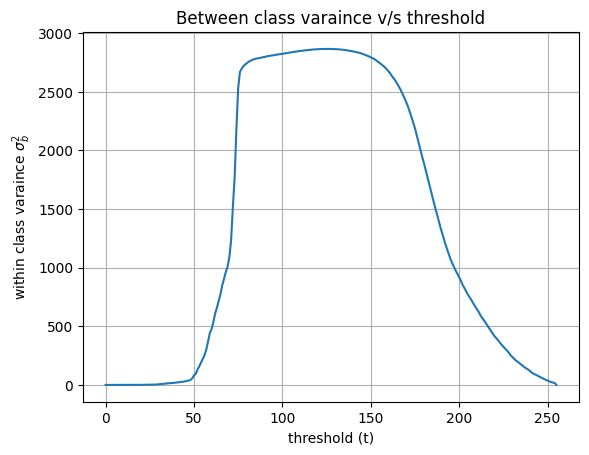

In [22]:
import matplotlib.pyplot as plt

plt.plot(var_b)
plt.title("Between class varaince v/s threshold")
plt.xlabel('threshold (t)')
plt.ylabel('within class varaince $\sigma^2_b$')
plt.grid(True)
plt.show()

#### *2.2.1 Offset by 20*

In [23]:
from assn1.image import image_offset
from assn1.binarize import otsu_between_class

## calculate offset image
offset= 20
img_off= image_offset(img, offset)

## calculate optimum threshold
var_b, t_opt= otsu_between_class(img_off)
print(f"Optimal Threshold for offset of \33[1;35m{offset}\33[0m is: \33[1;36m{t_opt}\33[0m")

Optimal Threshold for offset of 20 is: 144


Ideally, the threshold should go up by exactly the offset, but as the bright pixels move towards the 255 limit,
they all bundle up into a smaller cluster towards 255 thereby reducing class 1 variance. Hence, the threshold is 
pulled towards class 0 hence giving a value lesser than expected ($t_{opt} + offset$) in our case, instead of 145,
we get 144.

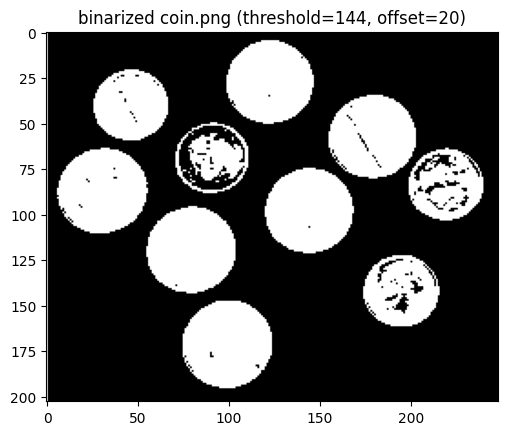

In [24]:
img_bin= binarize(img_off, t_opt)
display_image(img_bin, f'binarized coin.png (threshold={t_opt}, offset={offset})')

## *3. Adaptive Binarization*

Divide the image sudoku.png into overlapping blocks of specified sizes.
Apply Otsu’s binarization independently to each block. After processing, reconstruct the full
image by stitching the binarized blocks back together. In overlapping regions, determine the final
pixel value using a majority vote (i.e., select the most frequent binary value , 0 or 1, at each pixel
location across all overlapping blocks). Perform adaptive binarization with the following block, making sure 
each block overlaps the next one by 20%. (For example, if you use a 10x10 block, a 20% overlap means each 
block will share 2 pixels (20% of 10) with the next block.)

- (a) 5 × 5
- (b) 10 × 10
- (c) 25 × 25
- (d) 50 × 50
- (e) The full image (i.e., global binarization)

In which situations does a smaller block size perform better than a larger one, and vice versa?
Briefly comment on the visual differences and the advantages or disadvantages of using smaller
versus larger blocks for adaptive binarization.

The implementations are in `assn1/binarize.py` in a function called `adaptive_otsu`. It takes in block sizes and % overlap as input.
Also handles edge cases properly for blocks not fully fitting in block dimension

In [25]:
## Set up autoreload (for our modules)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


You might have to wait for a min here to run this!

In [26]:
from assn1.binarize import adaptive_otsu
from assn1.image import display_image, load_image

## load image
filepath= './images/sudoku.png'
img= load_image(filepath, grayscale=True)

## adaptive binarization
block_sizes= [(5,5), (10,10), (25,25), (50,50), img.shape]
bin_images= [adaptive_otsu(img, block_sizes[i]) for i in range(len(block_sizes))]

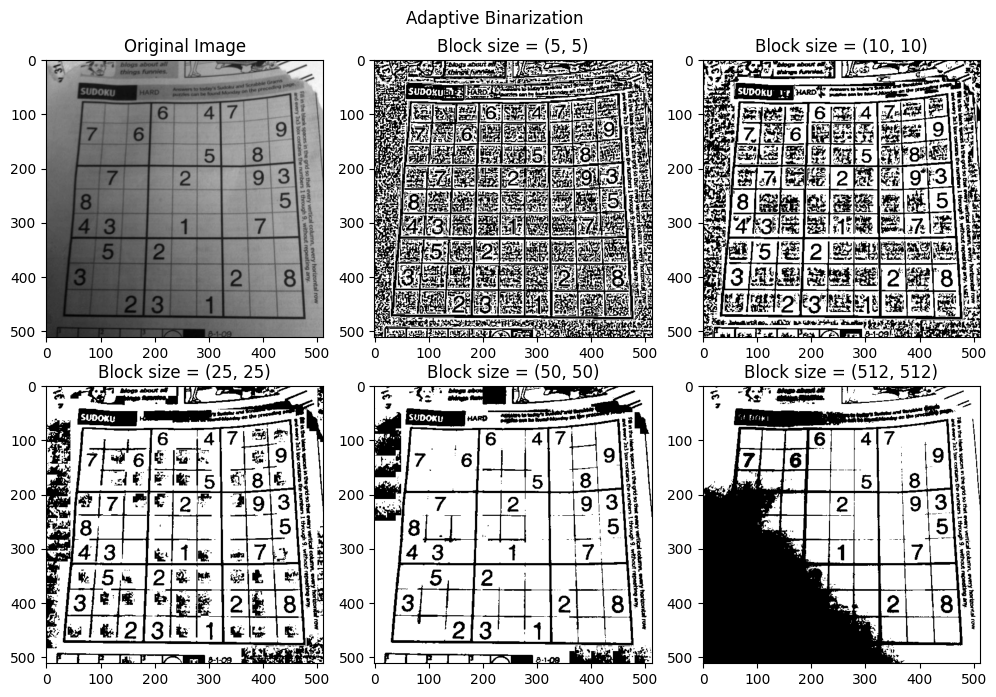

In [27]:
## display stuff
fig, ax= plt.subplots(ncols= 3, nrows= 2, figsize=(10, 7))
fig.suptitle('Adaptive Binarization')

ax[0,0].imshow(img, cmap='gray')
ax[0,0].set_title(f'Original Image')
ax[0,0].grid(False)
for i in range(2):
    for j in range(3):
        if i==0 and j==0: continue
        ax[i,j].imshow(bin_images[i*3+j - 1], cmap='gray')
        ax[i,j].set_title(f'Block size = {block_sizes[i*3 + j -1]}')
        ax[i,j].grid(False)

plt.tight_layout()
plt.show()

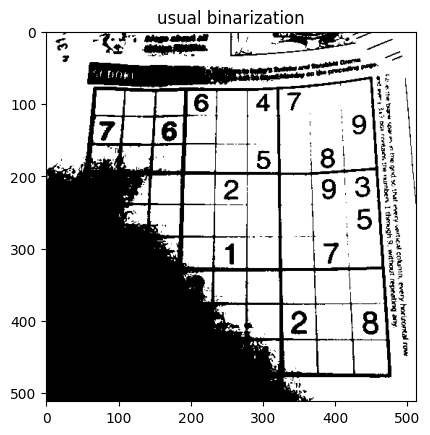

In [29]:
_, t= otsu_between_class(img)
b= binarize(img, t)
display_image(b,'usual binarization')

## *4. Connected Components*

Binarize the image `quote.png` and use connected component analysis
to extract characters, excluding punctuation marks. Identify the largest connected component
corresponding to a character, color it red, and return a modified image where this component is
highlighted in red over the original image.
In the class, we have seen connected component analysis using 4-neighbour connectivity. Formulate
the logic to implement and find the connected components using 8-neighbour connectivity of pixels.
The 8-neighbours of a pixel (x, y) is defined as:

$N_8(x, y) = \{(x − 1, y),(x − 1, y − 1),(x, y − 1),(x + 1, y − 1),
(x + 1, y),(x + 1, y + 1),(x, y + 1),(x − 1, y + 1)\}$




### *4.1. 4-neighbor*

$N_4(x,y) = \{(x-1, y), (x, y-1), (x+1, y), (x, y+1)\}$

In [1]:
## Set up autoreload (for our modules)
%load_ext autoreload
%autoreload 2

#### *4.1.1. Load Image*

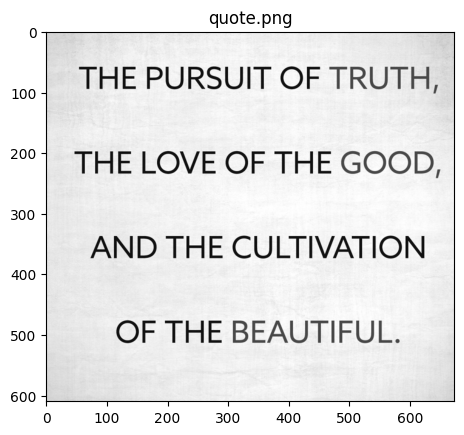

Image size: (610, 674)


In [2]:
from assn1.image import load_image, display_image

## usual load and display
filepath= './images/quote.png'
img= load_image(filepath, grayscale= True)
display_image(img, 'quote.png')
print(f"Image size: {img.shape}")

#### *4.1.2. Image Histogram*

For verifying if Otsu Algo will be a good approach

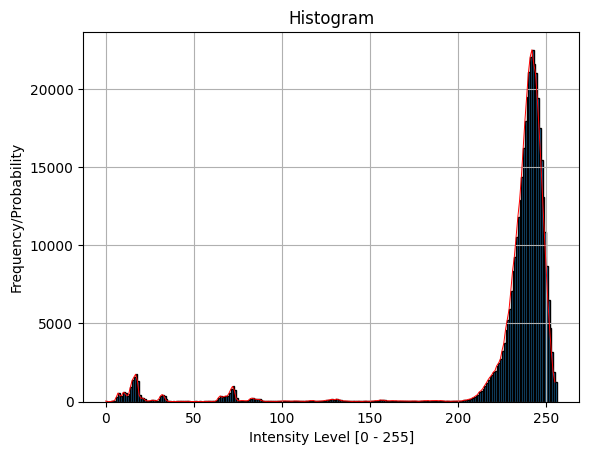

In [3]:
from assn1.histogram import histogram, display_histogram

## create histogram
H= histogram(img)
display_histogram(H)

Ok, there is a clear cluster of black and white with the white cluster dominating, but we want the characters to be white in a background of black. So, let's get the image negative.

#### *4.1.3. Negative of Image*

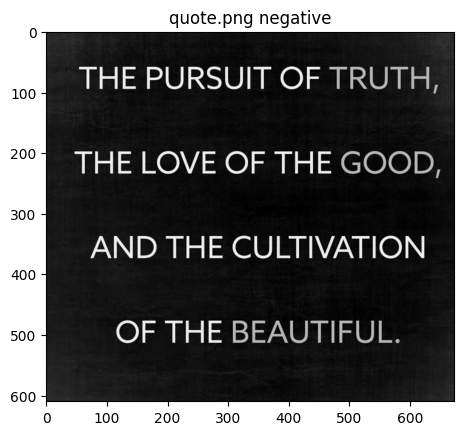

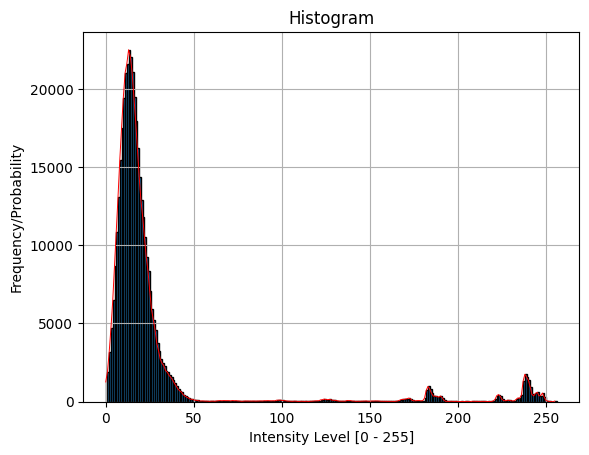

In [4]:
from assn1.constants import *

## negative of image + Histogram analysis
img_neg= (K-1)-img
display_image(img_neg, title='quote.png negative')
H= histogram(img_neg)
display_histogram(H)

#### *4.1.4. Binarize the image (Otsu Algo)*

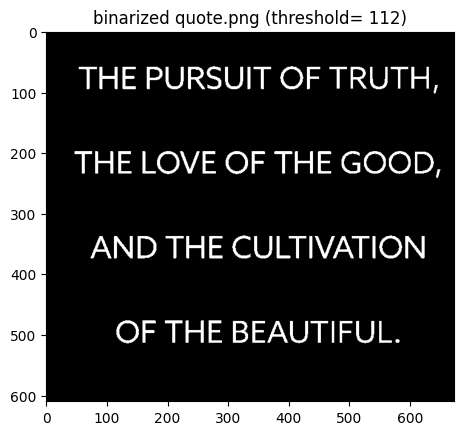

In [5]:
from assn1.binarize import otsu_between_class, binarize

## Otsu binarization
_, t_opt= otsu_between_class(img_neg)
bin_image= binarize(img_neg, t_opt)
display_image(bin_image, f'binarized quote.png (threshold= {t_opt})')

#### *4.1.5. Connected Component analysis (4-nbr) version*

(227, 546)


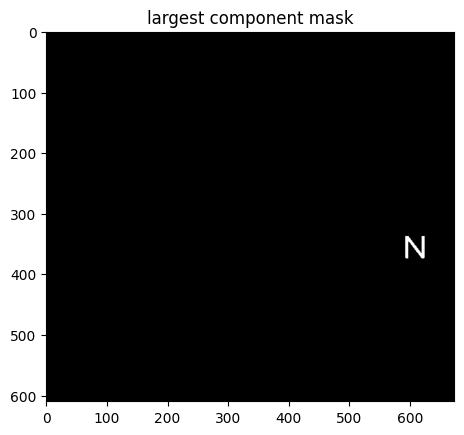

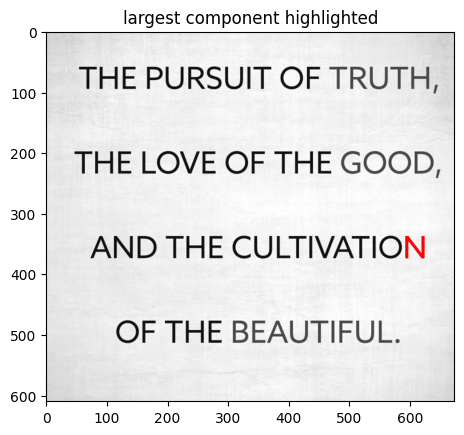

In [7]:
from assn1.cca import find_connected_components_4nbr, highlight_largest_connected_component_4nbr
import numpy as np

R, dsu= find_connected_components_4nbr(bin_img= bin_image)
print(dsu.get_largest_component())

mask= R == dsu.get_largest_component()[0]
final_img= np.repeat(img[:,:,np.newaxis], 3, axis=2)
final_img[mask] = [255,0,0]
display_image(mask, title='largest component mask')
display_image(final_img, title='largest component highlighted', cmap=None)

**Overall Process Condensed into few lines**

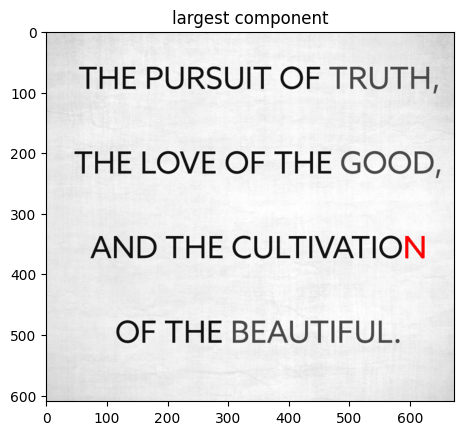

In [8]:
from assn1.image import load_image, display_image
from assn1.cca import highlight_largest_connected_component_4nbr

img= load_image('./images/quote.png', grayscale= True)
final_img= highlight_largest_connected_component_4nbr(img, color= [255,0,0])

display_image(final_img, title='largest component', cmap=None)

### 4.2. 8-neighbour version

(108, 546)


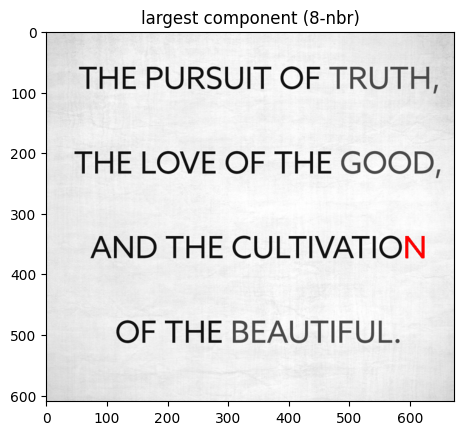

In [ ]:
from assn1.image import load_image, display_image
from assn1.cca import highlight_largest_connected_component_8nbr, find_connected_components_8nbr

R, dsu= find_connected_components_8nbr(bin_image)
print(dsu.get_largest_component())

final_img= highlight_largest_connected_component_8nbr(img)
display_image(final_img, title='largest component (8-nbr)', cmap=None)